In [481]:
import re
import pandas as pd
import numpy as np
import os

import gensim
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.corpus import stopwords

SEED = 42

import torch
import torch.nn as nn

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from nltk.corpus import stopwords
nltk.download('stopwords')
import math
from torch.autograd import Variable
from string import punctuation
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from collections import Counter

from sklearn import metrics


#from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [482]:
#performing the following steps on our data
#https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews

In [483]:
#importing the training data
#imdb_data=pd.read_csv('All_rated_reviews.csv')
imdb_data=pd.read_csv('All_rated_and_not_rated_reviews.csv')
imdb_data = imdb_data.loc[:, ~imdb_data.columns.str.match('Unnamed')]
print(imdb_data.shape)
imdb_data.head(5)

(37500, 4)


,user_id,rating,label,review
0,0,9.0,positive,Bromwell High is a cartoon comedy. It ran at t...
1,10000,8.0,positive,Homelessness (or Houselessness as George Carli...
2,10001,10.0,positive,Brilliant over-acting by Lesley Ann Warren. Be...
3,10002,7.0,positive,This is easily the most underrated film inn th...
4,10003,8.0,positive,This is not the typical Mel Brooks film. It wa...


In [484]:
#Summary of the dataset
imdb_data.describe()

,rating
count,25000.000000
mean,5.477720
std,3.466477
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


In [485]:
#sentiment count to see that the model is balanced
imdb_data['label'].value_counts()

positive    18750
negative    18750
Name: label, dtype: int64

In [486]:
imdb_data['label'] = imdb_data['label'].apply(lambda x: 1 if x == 'positive' else 0 )

## Text Normalization

In [487]:
#nltk.download()
#showing info http://nltk.github.com/nltk_data/

In [488]:
#Tokenization of text
tokenizer = ToktokTokenizer()
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

#### Removing noise from text

In [489]:
#Removing the html strips
# def strip_html(text):
#     soup = BeautifulSoup(text, "html.parser")
#     return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)
imdb_data['review'][0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

#### Removing special characters

In [490]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)
imdb_data['review'][0]

'Bromwell High is a cartoon comedy It ran at the same time as some other programs about school life such as Teachers My 35 years in the teaching profession lead me to believe that Bromwell Highs satire is much closer to reality than is Teachers The scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools I knew and their students When I saw the episode in which a student repeatedly tried to burn down the school I immediately recalled  at  High A classic line INSPECTOR Im here to sack one of your teachers STUDENT Welcome to Bromwell High I expect that many adults of my age think that Bromwell High is far fetched What a pity that it isnt'

#### Text Stemming

In [491]:
#Stemming the text (plays, playing, played -> play)
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)
imdb_data['review'][0]

'bromwel high is a cartoon comedi it ran at the same time as some other program about school life such as teacher my 35 year in the teach profess lead me to believ that bromwel high satir is much closer to realiti than is teacher the scrambl to surviv financi the insight student who can see right through their pathet teacher pomp the petti of the whole situat all remind me of the school i knew and their student when i saw the episod in which a student repeatedli tri to burn down the school i immedi recal at high a classic line inspector im here to sack one of your teacher student welcom to bromwel high i expect that mani adult of my age think that bromwel high is far fetch what a piti that it isnt'

#### Removing stopwords

In [492]:
#set stopwords to english
stop=set(stopwords.words('english'))
#print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)
imdb_data['review'][0]

'bromwel high cartoon comedi ran time program school life teacher 35 year teach profess lead believ bromwel high satir much closer realiti teacher scrambl surviv financi insight student see right pathet teacher pomp petti whole situat remind school knew student saw episod student repeatedli tri burn school immedi recal high classic line inspector im sack one teacher student welcom bromwel high expect mani adult age think bromwel high far fetch piti isnt'

In [493]:
def remove_punctuation(text):
    """
    Removing punctuation from our reviews
    Punctuations are !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    """
    #return map(lambda s: re.sub(r'[^\s\w]+', '', s).lower(), strings)
    all_text = ''.join([word for word in text if word not in punctuation])

    # split by new lines and spaces
    reviews_split = all_text.split('\n')
    all_text = ' '.join(reviews_split)
    # create a list of words
    words = all_text.split()
    return words

# text = imdb_data['review'][0]
# remove_punctuation(text)

imdb_data['review'] = imdb_data['review'].apply(lambda x: remove_punctuation(x))
#first 5 words of the review are
imdb_data['review'][0][:5]

['bromwel', 'high', 'cartoon', 'comedi', 'ran']

## Normalized reviews - are splitted into test train and validation sets

In [494]:
#Normalized val review
#imdb_data['review'][16875]

In [495]:
#Normalized test reviews
#imdb_data['review'][35625]

### Splitting the data set for training

In [496]:
print("Overall data set length is", imdb_data.shape[0]) 
print("From this index we see the negative reviews", int(imdb_data.shape[0]/2))

Overall data set length is 37500
From this index we see the negative reviews 18750


##### Calculation of indexes

In [497]:
#training set size will be
TRAINING_SET_PROP = 0.8
TEST_SET_PROP = VALID_SET_PROP = 0.1
TRAININ_SET_LAST_INDEX_POS = int(imdb_data.shape[0]/2*TRAINING_SET_PROP)
#TRAININ_SET_LAST_INDEX_POS
TEST_SET_LAST_IDX_POS = int(imdb_data.shape[0]/2*(TRAINING_SET_PROP+TEST_SET_PROP))
#TEST_SET_LAST_IDX_POS
TRAININ_SET_INDEX_NEG = int(imdb_data.shape[0]/2)
#TRAININ_SET_INDEX_NEG
TRAIN_SET_LAST_IDX_NEG = int(imdb_data.shape[0]/2 +imdb_data.shape[0]/2*(TRAINING_SET_PROP))
#TRAIN_SET_LAST_IDX_NEG
TEST_SET_LAST_INDX_NEG = int(imdb_data.shape[0]/2 +imdb_data.shape[0]/2*( TRAINING_SET_PROP+ TEST_SET_PROP))
#TEST_SET_LAST_INDX_NEG

In [498]:
#train dataset
train_reviews_pos=imdb_data[['review']][:TRAININ_SET_LAST_INDEX_POS]
train_sentiments_pos=imdb_data[['label']][:TRAININ_SET_LAST_INDEX_POS]
train_reviews_neg=imdb_data[['review']][TRAININ_SET_INDEX_NEG:TRAIN_SET_LAST_IDX_NEG]
train_sentiments_neg=imdb_data[['label']][TRAININ_SET_INDEX_NEG:TRAIN_SET_LAST_IDX_NEG]
train_reviews = train_reviews_pos.append(train_reviews_neg)
train_sentiments = train_sentiments_pos.append(train_sentiments_neg)

#test dataset
test_reviews_pos=imdb_data[['review']][TRAININ_SET_LAST_INDEX_POS:TEST_SET_LAST_IDX_POS]
test_sentiments_pos=imdb_data[['label']][TRAININ_SET_LAST_INDEX_POS:TEST_SET_LAST_IDX_POS]
test_reviews_neg=imdb_data[['review']][TRAIN_SET_LAST_IDX_NEG:TEST_SET_LAST_INDX_NEG]
test_sentiments_neg=imdb_data[['label']][TRAIN_SET_LAST_IDX_NEG:TEST_SET_LAST_INDX_NEG]
test_reviews = test_reviews_pos.append(test_reviews_neg)
test_sentiments = test_sentiments_pos.append(test_sentiments_neg)

#validation dataset
val_reviews_pos=imdb_data[['review']][TEST_SET_LAST_IDX_POS:TRAININ_SET_INDEX_NEG]
val_sentiments_pos=imdb_data[['label']][TEST_SET_LAST_IDX_POS:TRAININ_SET_INDEX_NEG]
val_reviews_neg=imdb_data[['review']][TEST_SET_LAST_INDX_NEG:imdb_data.shape[0]]
val_sentiments_neg=imdb_data[['label']][TEST_SET_LAST_INDX_NEG:imdb_data.shape[0]]
val_reviews = val_reviews_pos.append(val_reviews_neg)
val_sentiments = val_sentiments_pos.append(val_sentiments_neg)

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)
print(val_reviews.shape,test_sentiments.shape)
print("Proportions of test data", test_reviews.shape[0]/imdb_data.shape[0])

(30000, 1) (30000, 1)
(3750, 1) (3750, 1)
(3750, 1) (3750, 1)
Proportions of test data 0.1


## Cutting off irregular reviews by lenght

In [499]:
train_review_lens = Counter([len(x) for x in train_reviews['review']])
print("Zero-length reviews: {}".format(train_review_lens[0]))
print("Maximum review length: {}".format(max(train_review_lens)))

Zero-length reviews: 0
Maximum review length: 1503


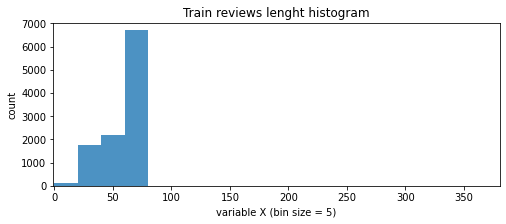

In [500]:
data = [len(x) for x in train_reviews['review']]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(data)-5, max(data)/4+5])
plt.hist(data, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

In [501]:
test_review_lens = Counter([len(x) for x in test_reviews['review']])
print("Zero-length reviews: {}".format(test_review_lens[0]))
print("Maximum review length: {}".format(max(test_review_lens)))

Zero-length reviews: 0
Maximum review length: 829


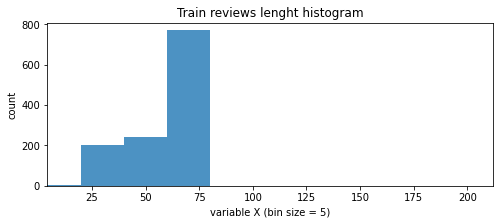

In [502]:
data = [len(x) for x in test_reviews['review']]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(data)-5, max(data)/4+5])
plt.hist(data, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

In [503]:
val_review_lens = Counter([len(x) for x in val_reviews['review']])
print("Zero-length reviews: {}".format(val_review_lens[0]))
print("Maximum review length: {}".format(max(val_review_lens)))

Zero-length reviews: 0
Maximum review length: 685


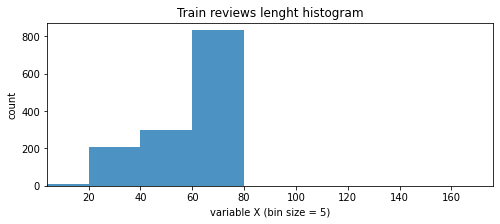

In [504]:
data = [len(x) for x in val_reviews['review']]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(data)-5, max(data)/4+5])
plt.hist(data, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

To decrease RNN training time the maximum review length will be cut to 100 words. For reviews shorter than 100, we'll pad with 0s. For reviews longer than 100, we can truncate them to the first 100 words.

https://github.com/udacity/deep-learning/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb

## Encoding the words with provided vocabulary

In [505]:
def read_vocab():
    '''file format: "idx : word" '''
    filename = 'imdb.vocab'
    path = r"train_data"
    word2id, id2word = {}, {}

    with open(os.path.join(path, filename), 'r', encoding="utf8") as file:
        for line in file:
            word = line.strip()
            idx = len(word2id)
            if word not in word2id:
                word2id[word] = idx
                id2word[idx] = word
    return word2id, id2word 

word2id, id2word  = read_vocab()
#word2id['with']

In [506]:
def encode_review(text, word2id):
    '''Converts text to numbers. Each word in the text is looked up in the dictionary
    and replaced by the corresponding number. If the word is not found - it is replaced with zero.
    '''
    #return torch.LongTensor([word2id[word] for word in text])
    #return torch.LongTensor([word2id[word] if word in word2id else 0 for word in text])
    return [word2id[word] if word in word2id else 0 for word in text]

#text = imdb_data['review'][0]
#encode_review(text, word2id)

In [507]:
train_reviews_ints = []
test_reviews_ints = []
val_reviews_ints = []

for each_review in train_reviews['review']:
    train_reviews_ints.append(encode_review(each_review, word2id))
for each_review in test_reviews['review']:
    test_reviews_ints.append(encode_review(each_review, word2id))
for each_review in val_reviews['review']:
    val_reviews_ints.append(encode_review(each_review, word2id))    

In [508]:
len(train_reviews_ints), len(test_reviews_ints)

(30000, 3750)

### Padding and cutting

In [509]:
seq_len = 100

#padding with zeroes
prepared_train_review = np.zeros((len(train_reviews_ints), seq_len), dtype=int)
prepared_test_review = np.zeros((len(test_reviews_ints), seq_len), dtype=int)
prepared_val_review = np.zeros((len(val_reviews_ints), seq_len), dtype=int)

#cutting the lenght
for review_number, int_review in enumerate(train_reviews_ints):
    prepared_train_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]

for review_number, int_review in enumerate(test_reviews_ints):
    prepared_test_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]
    
for review_number, int_review in enumerate(val_reviews_ints):
    prepared_val_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]    

In [510]:
#prepared_val_review[:10,:100]

### Embeddings

###### Develop word2vec embeddings

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [511]:
#https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df
#https://cnvrg.io/sentiment-analysis-python/

import gensim.downloader

# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))



['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [512]:
def embed(n_vocab, n_embed, embedding1 = False):
    # Download the "glove-twitter-100" or "word2vec-google-news-300" embeddings
    if embedding1:
        glove_path = gensim.downloader.load('word2vec-google-news-300', return_path=True)
        glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)
        
    else:
        glove_path = gensim.downloader.load('glove-twitter-100', return_path=True)
        try:
            glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
        except:
            glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)
        # glove_model = api.load('word2vec-ruscorpora-300')  If we want to load without saving localy 
    
    #loading the weights into torch Embeddings
    weights = torch.FloatTensor(glove_model.vectors)
    # Build nn.Embedding() layer
    embedding = nn.Embedding.from_pretrained(weights) 

    encoder = nn.Embedding(n_vocab, n_embed)
    #encoder(torch.from_numpy(prepared_train_review[0]))

    embedding.requires_grad_(False)
    return embedding

## Data Loders and batching

In [513]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(prepared_train_review), torch.from_numpy(train_sentiments.to_numpy()))
valid_data = TensorDataset(torch.from_numpy(prepared_test_review), torch.from_numpy(test_sentiments.to_numpy()))
test_data = TensorDataset(torch.from_numpy(prepared_val_review), torch.from_numpy(val_sentiments.to_numpy()))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [514]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Training

In [515]:
#Code from here
#https://github.com/emadRad/lstm-gru-pytorch/blob/master/lstm_gru.ipynb
#https://github.com/piEsposito/pytorch-lstm-by-hand/blob/master/LSTM.ipynb


#theory from here
#https://blog.floydhub.com/gru-with-pytorch/

# yonai referance:
# https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
# https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948


# DEFINE THE LSTM MODEL
class CustomLSTM(nn.Module):
    #def __init__(self, input_sz, hidden_sz):
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5, embedding1 = False):
        super().__init__()
        self.n_embed = n_embed        
        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM
        
        if embedding1:
            self.embedding = embed(n_vocab, n_embed, embedding1 = False)
        else:
            self.embedding = embed(n_vocab, n_embed)
        
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        self.W = nn.Parameter(torch.Tensor(n_embed, n_hidden * 4))
        self.U = nn.Parameter(torch.Tensor(n_hidden, n_hidden * 4))
        self.bias = nn.Parameter(torch.Tensor(n_hidden * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.n_hidden)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, 
                init_states=None):
        
        x = self.embedding(x)    # (batch_size, seq_length, n_embed)

        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.n_hidden).to(x.device), 
                        torch.zeros(bs, self.n_hidden).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.n_hidden
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        hidden_seq, (h_t, c_t)
        lstm_out, h = hidden_seq, (h_t, c_t)      # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h
    
    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

In [560]:
# INSTANTIATE THE MODEL W/ HYPERPARAMETERS
n_vocab = len(word2id)
n_embed = 100
n_hidden = 12
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 2

net = CustomLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

In [561]:
# DEFINE LOSS & OPTIMIZER
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

In [562]:
#TRAIN THE NETWORK!
def train_lstm(net):
    train_losses = []
    val_losses = []
    print_every = 100
    step = 0
    n_epochs = 10  # validation loss increases from ~ epoch 3 or 4
    clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    #auc = []
    #fpr = []
    #tpr = []

    test_losses = []
    test_accuracies = []
    

    for epoch in range(n_epochs):
        train_lst = []
        val_lst = []
        h = net.init_hidden(batch_size)

        for inputs, labels in train_loader:
            step += 1
            inputs, labels = inputs.to(device), labels.to(device)

            # making requires_grad = False for the latest set of h
            h = tuple([each.data for each in h])   

            net.zero_grad()
            output, h = net(inputs)
            loss = criterion(output.squeeze(), labels.float().squeeze())
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), clip)
            optimizer.step()

            if (step % print_every) == 0:            
                ######################
                ##### VALIDATION #####
                ######################
                net.eval()
                valid_losses = []
                v_h = net.init_hidden(batch_size)

                for v_inputs, v_labels in valid_loader:
                    v_inputs, v_labels = inputs.to(device), labels.to(device)

                    v_h = tuple([each.data for each in v_h])

                    v_output, v_h = net(v_inputs)
                    v_loss = criterion(v_output.squeeze(), v_labels.float().squeeze())
                    valid_losses.append(v_loss.item())

                print("Epoch: {}/{}".format((epoch+1), n_epochs),
                      "Step: {}".format(step),
                      "Training Loss: {:.4f}".format(loss.item()),
                      "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
                
                train_lst.append(loss.item())
                val_lst.append(np.mean(valid_losses))
                net.train()
        
        #TEST THE TRAINED MODEL ON THE TEST SET
        net.eval()
        test_lst = []
        num_correct = 0
        test_h = net.init_hidden(batch_size)
        outputs = []
        targets = []
        for inputs, labels in test_loader:
            test_h = tuple([each.data for each in test_h])
            test_output, test_h = net(inputs)
            loss = criterion(test_output.squeeze(), labels.float().squeeze())
            test_lst.append(loss.item())

            preds = torch.round(test_output.squeeze())
            correct_tensor = preds.eq(labels.float().view_as(preds))
            correct = np.squeeze(correct_tensor.numpy())
            num_correct += np.sum(correct)
            
            # outputs.append(preds)
            

        test_losses.append(np.mean(test_lst))
        test_accuracies.append(num_correct/len(test_loader.dataset))
        
        train_losses.append(np.mean(train_lst))
        val_losses.append(np.mean(val_lst))
                
    return net, train_losses, val_losses, test_losses, test_accuracies

# Results 

In [563]:
net, train_losses, val_losses, test_losses, test_accuracies = train_lstm(net)

C:\Users\User\AppData\Local\Temp/ipykernel_90664/1753159545.py:35: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/10 Step: 100 Training Loss: 0.6840 Validation Loss: 0.6682
Epoch: 1/10 Step: 200 Training Loss: 0.6513 Validation Loss: 0.6674
Epoch: 1/10 Step: 300 Training Loss: 0.6606 Validation Loss: 0.6575
Epoch: 1/10 Step: 400 Training Loss: 0.6764 Validation Loss: 0.6495
Epoch: 1/10 Step: 500 Training Loss: 0.6653 Validation Loss: 0.6690
Epoch: 1/10 Step: 600 Training Loss: 0.5609 Validation Loss: 0.5401
Epoch: 2/10 Step: 700 Training Loss: 0.6631 Validation Loss: 0.6474
Epoch: 2/10 Step: 800 Training Loss: 0.5968 Validation Loss: 0.5822
Epoch: 2/10 Step: 900 Training Loss: 0.6460 Validation Loss: 0.6457
Epoch: 2/10 Step: 1000 Training Loss: 0.6002 Validation Loss: 0.5319
Epoch: 2/10 Step: 1100 Training Loss: 0.4185 Validation Loss: 0.3829
Epoch: 2/10 Step: 1200 Training Loss: 0.4915 Validation Loss: 0.4504
Epoch: 3/10 Step: 1300 Training Loss: 0.5003 Validation Loss: 0.4892
Epoch: 3/10 Step: 1400 Training Loss: 0.4338 Validation Loss: 0.4267
Epoch: 3/10 Step: 1500 Training Loss: 0.452

In [564]:
def test_results(net):
    #TEST THE TRAINED MODEL ON THE TEST SET
    net.eval()
    test_losses = []
    num_correct = 0
    test_h = net.init_hidden(batch_size)

    for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])
        test_output, test_h = net(inputs)
        loss = criterion(test_output.squeeze(), labels.float().squeeze())
        test_losses.append(loss.item())

        preds = torch.round(test_output.squeeze())
        correct_tensor = preds.eq(labels.float().view_as(preds))
        correct = np.squeeze(correct_tensor.numpy())
        num_correct += np.sum(correct)

    print("Test Loss: {:.4f}".format(np.mean(test_losses)))
    print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))
    


In [565]:
test_results(net)

Test Loss: 0.4882
Test Accuracy: 0.78


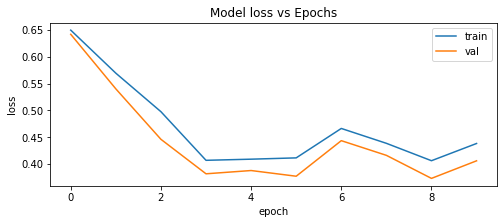

In [566]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

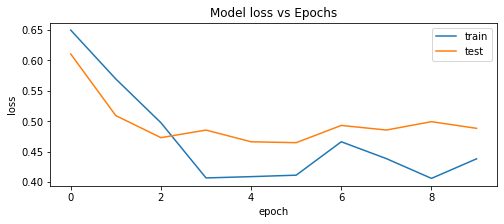

In [567]:
# Verifying the absence of overfitting
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

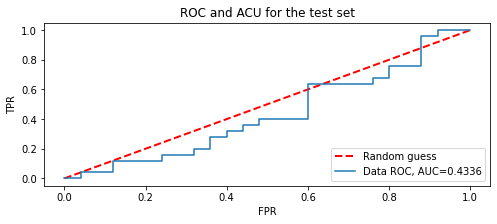

In [568]:
#ROC curve and calculate AUC for the test set
y_test = next(iter(test_loader))[1].numpy().squeeze()
x_test = next(iter(test_loader))[0]
test_out, test_h = net(next(iter(test_loader))[0])

plt.rcParams["figure.figsize"] = (8,3)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
y_pred_proba = test_out.detach().numpy()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Data ROC, AUC="+str(auc))
plt.title('ROC and ACU for the test set')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.show()

## second embedding

In [569]:
n1_embed = 300
net1 = CustomLSTM(n_vocab, n1_embed, n_hidden, n_output, n_layers, embedding1 = True)

In [570]:
net1, train_losses1, val_losses1, test_losses1, test_accuracies1 = train_lstm(net1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x100 and 300x48)

In [ ]:
test_results(net1)

In [ ]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(train_losses1)
plt.plot(val_losses1)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# Verifying the absence of overfitting
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(train_losses1)
plt.plot(test_losses1)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#ROC curve and calculate AUC for the test set
y_test = next(iter(test_loader))[1].numpy().squeeze()
x_test = next(iter(test_loader))[0]
test_out, test_h = net(next(iter(test_loader))[0])

plt.rcParams["figure.figsize"] = (8,3)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
y_pred_proba = test_out.detach().numpy()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Data ROC, AUC="+str(auc))
plt.title('ROC and ACU for the test set')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.show()

# To train embeddings of ur own

In [ ]:
#https://rguigoures.github.io/word2vec_pytorch/